In [1]:
from torchmanager_core import devices
from diffusion import Manager

In [2]:
batch_size: int = 64
data = "cifar10"
data_dir = "~/Public/share/Data/"
device = devices.GPUS[0]
image_size = (32, 32)
model_path = "experiments/cifar10_reverse_sigmoid.exp/checkpoints/last.model"
# pt_model_path = "~/Documents/Models/diffusion.pth"

In [3]:
manager: Manager = Manager.from_checkpoint(model_path, map_location=device) # type: ignore

In [5]:
# import data
from torchvision import datasets, transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocessing = transforms.Compose([
    transforms.ToTensor(),
    normalize
])
dataset = datasets.SVHN(data_dir, transform=preprocessing, download=True)
# dataset, _, _, _ = data.load_cifar10(data_dir, batch_size, normalize=None, random_flip=False)

Using downloaded and verified file: /home/kisonho/Public/share/Data/train_32x32.mat


In [6]:
import torch

y_test: list[torch.Tensor] = []
labels: list[torch.Tensor] = []

for img, label in dataset:
    if len(labels) > 10:
        break
    elif label not in labels:
        img_tensor: torch.Tensor = img
        labels.append(label)
        y_test.append(img_tensor.unsqueeze(0))

In [7]:
y_test = torch.cat(y_test)
y_test.shape

torch.Size([10, 3, 32, 32])

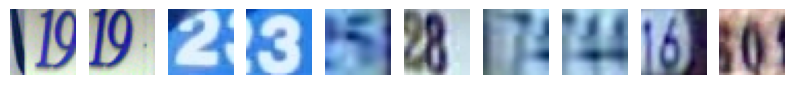

In [8]:
from matplotlib import pyplot as plt

_, axs = plt.subplots(1, 10, figsize=(10, 1))
axs = axs.ravel() # type: ignore

for i, img in enumerate(y_test):
    img = (img - img.min()) / (img.max() - img.min())
    img = img.clip(0,1)
    axs[i].imshow(img.permute(1,2,0))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['left'].set_visible(False)

plt.show()

In [9]:
from diffusion.managers.utils import _get_index_from_list

T = 1000
t = torch.full((batch_size,), T, dtype=torch.long)
noise = torch.randn_like(y_test)

sqrt_alphas_cumprod_t = _get_index_from_list(manager.beta_space.sqrt_alphas_cumprod, t, y_test.shape)
sqrt_one_minus_alphas_cumprod_t = _get_index_from_list(manager.beta_space.sqrt_one_minus_alphas_cumprod, t, y_test.shape)
data = sqrt_alphas_cumprod_t * y_test + sqrt_one_minus_alphas_cumprod_t * noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

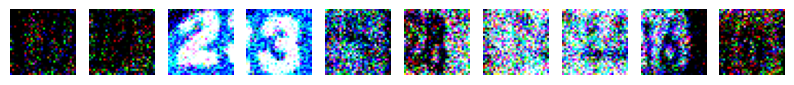

In [10]:
_, axs = plt.subplots(1, 10, figsize=(10, 1))
axs = axs.ravel() # type: ignore

for i, noise in enumerate(data):
    axs[i].imshow(noise.permute(1,2,0))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['left'].set_visible(False)

In [11]:
from diffusion.scheduling import BetaSpace

manager.beta_space = BetaSpace(manager.beta_space.betas[:T])
manager.time_steps = T

In [4]:
import diffusion, torch

print("Generating images...")
preds: list[torch.Tensor] = manager.predict(batch_size, image_size, device=device, show_verbose=True)

predicted_dataset = diffusion.data.Dataset(preds, batch_size)
preds = [img.unsqueeze(0) for img in preds]

Generating images...


Sampling loop time step: 100%|██████████| 1000/1000 [00:33<00:00, 29.48it/s]


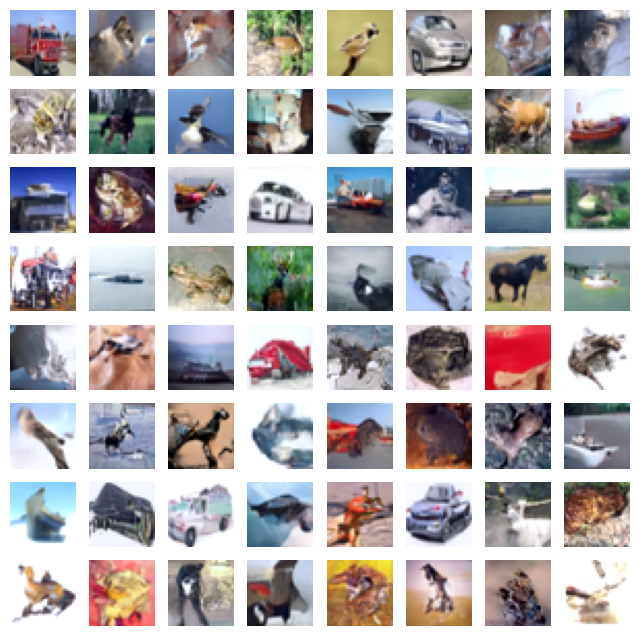

In [5]:
from matplotlib import pyplot as plt

_, axs = plt.subplots(8, 8, figsize=(8, 8))
axs = axs.ravel() # type: ignore

for i, img in enumerate(torch.cat(preds)):
    img = img.cpu()
    img /= (img.max() - img.min())
    img += 0.5
    img = img.clip(0,1)
    axs[i].imshow(img.permute(1,2,0))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['left'].set_visible(False)

plt.show()

In [14]:
from torchmanager.losses import MSE

mse = MSE()

In [15]:
zipped_imgs = zip([img.squeeze(0) for img in preds], [img.squeeze(0) for img in y_test])

for i, (img, y) in enumerate(zipped_imgs):
    # normalize img
    img = (img - img.min()) / (img.max() - img.min())
    img = img.clip(0,1)

    # normalize y
    y = (y - y.min()) / (y.max() - y.min())
    y = y.clip(0,1)
    mse(img, y)

In [16]:
mse.result

tensor(0.0105)